# Dynamic properties of NiAl alloy

In this tutorial, we study the dynamics of an alloy, both in an ordered and disordered phase. The focus will be on multi-component aspects. Note that this tutorial uses a small simulation cell (i.e., few $\boldsymbol{q}$-points) and a short trajectory in order to limit the runtime. In practice, one needs to tune these parameters as well as the **dynasor** parameters for optimal results.

In order to do this, we first generate an ordered and a disordered NiAl structure and then generate MD trajectories for these using [GPUMD](https://gpumd.org/) with the [UNEP model](https://zenodo.org/records/10081677). For the purpose of this tutorial, we assume that the molecular dynamics trajectories have already been created beforehand with GPUMD. See `examples/NiAl-ordered-and-disordered/NiAl-runmd.py` for the runscript.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from ase.build import bulk
from seekpath import get_path

from dynasor.qpoints import get_supercell_qpoints_along_path
from dynasor import compute_dynamic_structure_factors, Trajectory
from dynasor.units import radians_per_fs_to_meV as conversion_factor

## Set up Trajectory with atom type information

**dynasor** supports multiple different trajectory formats via internal readers as well as via [mdanalysis](https://www.mdanalysis.org/) and [ase](https://wiki.fysik.dtu.dk/ase/).
Here, we use the internal ExtXYZ reader. To begin with, we read the full trajectory for the ordered NiAl (B2 phase, so 50% Ni and 50% Al). The length and time units of the MD trajectory are specified with the `length_unit` and `time_unit` keyword. The units of GPUMD are the same as the internal **dynasor** units, so in this case it is reduntant to specify them, but we here show how it can be done in case your favorite MD software has different internal units.

In [3]:
traj = Trajectory(f'ordered/dump.xyz', 
                  trajectory_format='extxyz',
                  length_unit='Angstrom', 
                  time_unit='fs',
                  frame_step=1,
                  frame_stop=None)

INFO: Trajectory file: ordered/dump.xyz
INFO: Total number of particles: 27648
INFO: Number of atom types: 1
INFO: Number of atoms of type X: 27648
INFO: Simulation cell (in Angstrom):
[[68.64  0.    0.  ]
 [ 0.   68.64  0.  ]
 [ 0.    0.   68.64]]


A short summary of the content of the `traj` object can be obtained via the `display` command (in notebooks) or `print` (in notebooks or scripts).

In [4]:
display(traj)

When we create the `Trajectory` object in the simplest way, as above, we see that all atoms in the trajectory are taken to be of a single, unknown, type 'X'. We know that this is not the case for our trajectory, since it contains two atom types, 'Ni' and 'Al'. 

In order to pass on this information to the `Trajectory` object, we need to specify the `atomic_indices` keyword. Let's remake the `Trajectory` object, but this time with the addition of reading the atom types directly from the trajectory. 

In [5]:
traj = Trajectory(f'ordered/dump.xyz', 
                  trajectory_format='extxyz',
                  atomic_indices='read_from_trajectory',
                  length_unit='Angstrom', 
                  time_unit='fs',
                  frame_step=1,
                  frame_stop=None)

INFO: Trajectory file: ordered/dump.xyz
INFO: Total number of particles: 27648
INFO: Number of atom types: 2
INFO: Number of atoms of type Al: 13824
INFO: Number of atoms of type Ni: 13824
INFO: Simulation cell (in Angstrom):
[[68.64  0.    0.  ]
 [ 0.   68.64  0.  ]
 [ 0.    0.   68.64]]


In [6]:
display(traj)

In [7]:
traj.atomic_indices

{'Al': array([    1,     3,     5, ..., 27643, 27645, 27647]),
 'Ni': array([    0,     2,     4, ..., 27642, 27644, 27646])}

Now our `Trajectory` object contains information about the different atomic types! Note that not all available readers and MD trajectory types support directly reading the atom types from the trajectory. If `atomic_indices='read_from_trajectory'` fails, there are two other options to specify the atomic indices:

1. Create a dictionary where the keys are the species and the values are the atomic indices
2. Create a path to an index file ([Gromacs ndx-style](https://manual.gromacs.org/current/reference-manual/file-formats.html#ndx))

In this case, if `'read_from_trajectory'` had failed, we could have used the first alternative by creating a dictionary like this

In [8]:
atomic_indices_dict = {'Ni': np.arange(0, traj.n_atoms, 2), # even indices
                       'Al': np.arange(1, traj.n_atoms, 2)} # odd indices

In [9]:
traj = Trajectory(f'ordered/dump.xyz', 
                  trajectory_format='extxyz',
                  atomic_indices=atomic_indices_dict,
                  length_unit='Angstrom', 
                  time_unit='fs',
                  frame_step=1,
                  frame_stop=None)

INFO: Trajectory file: ordered/dump.xyz
INFO: Total number of particles: 27648
INFO: Number of atom types: 2
INFO: Number of atoms of type Ni: 13824
INFO: Number of atoms of type Al: 13824
INFO: Simulation cell (in Angstrom):
[[68.64  0.    0.  ]
 [ 0.   68.64  0.  ]
 [ 0.    0.   68.64]]


In [10]:
traj.atomic_indices

{'Ni': array([    0,     2,     4, ..., 27642, 27644, 27646]),
 'Al': array([    1,     3,     5, ..., 27643, 27645, 27647])}

Note that we are not limited to atomic species, but we could use this to group atoms in other ways too. For example, imagine a system containing bulk and surface atoms for which we would like to study the dynamics separately. We could easily do this by creating a dictionary {'bulk': ... ,'surface': ... } in the same fashion as above.

Now that we have explored different ways to set up a trajectory containing information about the atom types, let's use this to perform a **dynasor** calculation and study which atom types in the system give rise to which features in $S(\boldsymbol{q},\omega)$.

## Set up path through Brillouin zone

We need a path through the Brillouin zone, for which we follow the approach introduced in the ["Dynamic properties of FCC-Al" tutorial](https://dynasor.materialsmodeling.org/tutorials/aluminum_solid_dynamic.html). In this case, we use the same path through the Brillouin zone for NiAl as for pure Al.

In [11]:
repeats = 24 # We simulated a 24x24x24 supercell
prim = bulk('Al', a=traj.cell[0][0]/repeats)
path_info = get_path((prim.cell, prim.get_scaled_positions(), prim.numbers))
point_coordinates = path_info['point_coords']
path = path_info['path']
display(point_coordinates)
display(path)

{'GAMMA': [0.0, 0.0, 0.0],
 'X': [0.5, 0.0, 0.5],
 'L': [0.5, 0.5, 0.5],
 'W': [0.5, 0.25, 0.75],
 'W_2': [0.75, 0.25, 0.5],
 'K': [0.375, 0.375, 0.75],
 'U': [0.625, 0.25, 0.625]}

[('GAMMA', 'X'),
 ('X', 'U'),
 ('K', 'GAMMA'),
 ('GAMMA', 'L'),
 ('L', 'W'),
 ('W', 'X')]

In [12]:
q_segments = get_supercell_qpoints_along_path(
    path, point_coordinates, prim.cell, traj.cell)
q_points = np.vstack(q_segments)

## Compute correlation functions

Now we have prepared everything we need to be able to compute the dynamic structure factor. 

**Note**: The `Trajectory` object is an "exhaustible iterable" which means that once we have iterated over all frames, it is exhausted. Therefore, one needs to "reload" the trajectory before calling `compute_dynamic_structure_factors` again to ensure that the entire trajectory is available for analysis.

The below code cell takes about 10-15 minutes to run on a common work station. If you would like to reduce this, set `frame_stop` above to only read a fraction of the trajectory. 

In [13]:
delta_t = 5.0 # MD time step used (fs)
dump_every = 5 # How often the frames were dumped during MD

sample = compute_dynamic_structure_factors(traj, q_points, 
                                           dt=delta_t*dump_every, 
                                           window_size=2000,
                                           window_step=100,
                                           calculate_currents=True)

INFO: Spacing between samples (frame_step): 1
INFO: Time between consecutive frames in input trajectory (dt): 25.0 fs
INFO: Time between consecutive frames used (dt * frame_step): 25.0 fs
INFO: Time window size (dt * frame_step * window_size): 50000.0 fs
INFO: Angular frequency resolution: dw = 0.000063 rad/fs = 0.041 meV
INFO: Maximum angular frequency (dw * window_size): 0.125664 rad/fs = 82.713 meV
INFO: Nyquist angular frequency (2pi / frame_step / dt / 2): 0.125664 rad/fs = 82.713 meV
INFO: Calculating current (velocity) correlations
INFO: Number of q-points: 90


In [14]:
display(sample)

DynamicSample
Atom types: ['Al', 'Ni']
Pairs: [('Al', 'Al'), ('Al', 'Ni'), ('Ni', 'Ni')]
Particle counts: {'Ni': 13824, 'Al': 13824}
Simulations cell:
[[68.64  0.    0.  ]
 [ 0.   68.64  0.  ]
 [ 0.    0.   68.64]]
omega           with shape: (2001,)
q_points        with shape: (90, 3)
time            with shape: (2001,)
Clqt            with shape: (90, 2001)
Clqt_Al_Al      with shape: (90, 2001)
Clqt_Al_Ni      with shape: (90, 2001)
Clqt_Ni_Ni      with shape: (90, 2001)
Clqw            with shape: (90, 2001)
Clqw_Al_Al      with shape: (90, 2001)
Clqw_Al_Ni      with shape: (90, 2001)
Clqw_Ni_Ni      with shape: (90, 2001)
Ctqt            with shape: (90, 2001)
Ctqt_Al_Al      with shape: (90, 2001)
Ctqt_Al_Ni      with shape: (90, 2001)
Ctqt_Ni_Ni      with shape: (90, 2001)
Ctqw            with shape: (90, 2001)
Ctqw_Al_Al      with shape: (90, 2001)
Ctqw_Al_Ni      with shape: (90, 2001)
Ctqw_Ni_Ni      with shape: (90, 2001)
Fqt             with shape: (90, 2001)
Fqt_coh         with shape: (90, 2001)
Fqt_coh_Al_Al   with shape: (90, 2001)
Fqt_coh_Al_Ni   with shape: (90, 2001)
Fqt_coh_Ni_Ni   with shape: (90, 2001)
Sqw             with shape: (90, 2001)
Sqw_coh         with shape: (90, 2001)
Sqw_coh_Al_Al   with shape: (90, 2001)
Sqw_coh_Al_Ni   with shape: (90, 2001)
Sqw_coh_Ni_Ni   with shape: (90, 2001)

## Visualize dynamic structure factor

We can now visualize $S(\boldsymbol{q},\omega)$ using the same approach introduced in the ["Dynamic properties of FCC-Al" tutorial](https://dynasor.materialsmodeling.org/tutorials/aluminum_solid_dynamic.html), i.e., in the form of a heatmap in the momentum-frequency plane. To do so, we first need the running pair-wise distance betwen $\boldsymbol{q}$-points along the path.

In [15]:
q_distances = []
q_labels = dict()

# starting point
qr = 0.0

# collect labels and q-distances along the entire q-point path
for it, q_segment in enumerate(q_segments):
    q_distances.append(qr)
    q_labels[qr] = path[it][0]
    for qi, qj in zip(q_segment[1:], q_segment[:-1]):
        qr += np.linalg.norm(qi - qj)
        q_distances.append(qr)

q_labels[qr] = path[-1][1]
q_distances = np.array(q_distances)

First, we visualize the full dynamic structure factor, which, in addition to acoustic branches similar to those we saw in the ["Dynamic properties of FCC-Al" tutorial](https://dynasor.materialsmodeling.org/tutorials/aluminum_solid_dynamic.html), also reveals optical branches, as expected in a multi-component system. As the dynamic structure factor only contains information about the longitudinal modes, we can in addition visualize the sum of the longitudinal and transverse current correlation functions, to study the full dispersion.

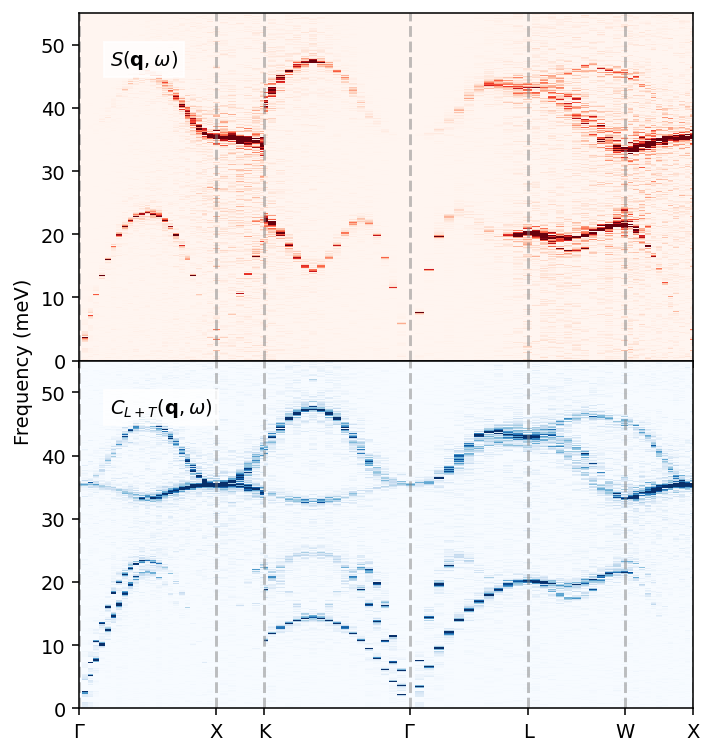

In [16]:
fig, axes = plt.subplots(figsize=(5.2, 5.5), nrows=2, dpi=140,
                         sharex=True, sharey=True)

ax = axes[0]
ax.pcolormesh(q_distances, conversion_factor * sample.omega,
              sample.Sqw_coh.T, cmap='Reds', vmin=0, vmax=8)
ax.text(0.05, 0.85, '$S(\mathbf{q}, \omega)$', transform=ax.transAxes,
        bbox={'color': 'white', 'alpha': 0.8, 'pad': 3})

ax = axes[1]
ax.pcolormesh(q_distances, conversion_factor * sample.omega,
              sample.Clqw.T + sample.Ctqw.T, cmap='Blues', vmin=0, vmax=10e-3)
ax.text(0.05, 0.85, '$C_{L+T}(\mathbf{q}, \omega)$', transform=ax.transAxes,
        bbox={'color': 'white', 'alpha': 0.8, 'pad': 3})

for ax in axes:
    xticks = []
    xticklabels = []
    for q_dist, q_label in q_labels.items():
        ax.axvline(q_dist, c='0.5', alpha=0.5, ls='--')
        xticks.append(q_dist)
        xticklabels.append(q_label.replace('GAMMA', r'$\Gamma$'))

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)

ax.set_xlim([0, q_distances.max()])
ax.set_ylim([0, 55])

ax.set_ylabel('Frequency (meV)', y=1)

fig.tight_layout()
fig.subplots_adjust(hspace=0)

Note again that these correlations are not converged and that one in practice would need to tailor the simulation cell size, the trajectory length, as well as **dynasor** parameters (`windown_size`, `window_step`, etc.) to reach convergence.

Since we have added information about atom types to the trajectory, our `Sample` object also contains the partial structure factors and current correlations, which we can visualize. By doing so, we can learn more about which features in the dispersion relation stem from which atom types in the system.

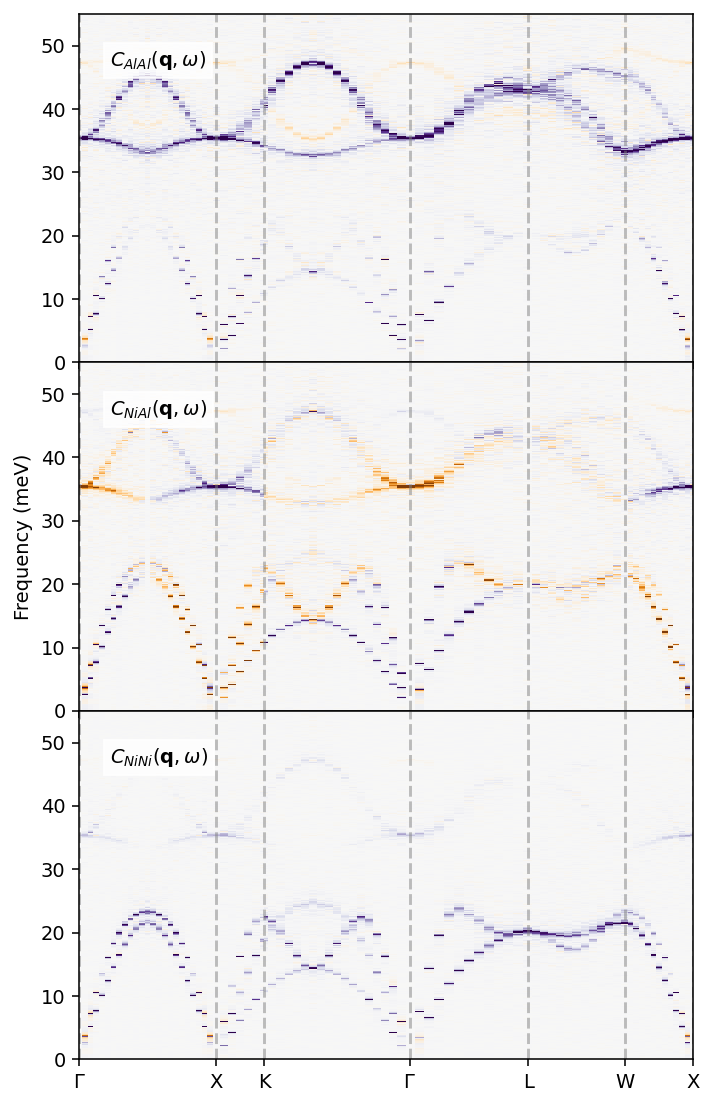

In [17]:
fig, axes = plt.subplots(figsize=(5.2, 8), nrows=3, dpi=140,
                         sharex=True, sharey=True)

ax = axes[0]
ax.pcolormesh(q_distances, conversion_factor * sample.omega,
              sample.Clqw_Al_Al.T + sample.Ctqw_Al_Al.T, cmap='PuOr', vmin=-10e-3, vmax=10e-3)
ax.text(0.05, 0.85, '$C_{AlAl}(\mathbf{q}, \omega)$', transform=ax.transAxes,
        bbox={'color': 'white', 'alpha': 0.8, 'pad': 3})

ax = axes[1]
ax.pcolormesh(q_distances, conversion_factor * sample.omega,
              sample.Clqw_Al_Ni.T + sample.Ctqw_Al_Ni.T, cmap='PuOr', vmin=-10e-3, vmax=10e-3)
ax.text(0.05, 0.85, '$C_{NiAl}(\mathbf{q}, \omega)$', transform=ax.transAxes,
        bbox={'color': 'white', 'alpha': 0.8, 'pad': 3})

ax = axes[2]
ax.pcolormesh(q_distances, conversion_factor * sample.omega,
              sample.Clqw_Ni_Ni.T + sample.Ctqw_Ni_Ni.T, cmap='PuOr', vmin=-10e-3, vmax=10e-3)
ax.text(0.05, 0.85, '$C_{NiNi}(\mathbf{q}, \omega)$', transform=ax.transAxes,
        bbox={'color': 'white', 'alpha': 0.8, 'pad': 3})

for ax in axes:
    xticks = []
    xticklabels = []
    for q_dist, q_label in q_labels.items():
        ax.axvline(q_dist, c='0.5', alpha=0.5, ls='--')
        xticks.append(q_dist)
        xticklabels.append(q_label.replace('GAMMA', r'$\Gamma$'))

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)

ax.set_xlim([0, q_distances.max()])
ax.set_ylim([0, 55])

axes[1].set_ylabel('Frequency (meV)')

fig.tight_layout()
fig.subplots_adjust(hspace=0)


We can here clearly see which atom types contribute to which parts of the dispersion relations, as well as note that some parts have negative sign (orange), in particular for the NiAl partial current correlation.

## Dynamics in disoreded NiAl

Now we want to see what changes in the dynamics of disordered NiAl compared to ordered NiAl. To this end, we can use the same procedure as above and compute the correlations, using the same path through the Brillouin zone to be able to compare the two.

In [18]:
traj_disordered = Trajectory(f'disordered/dump.xyz', 
                             trajectory_format='extxyz',
                             atomic_indices='read_from_trajectory',
                             length_unit='Angstrom', 
                             time_unit='fs',
                             frame_step=1,
                             frame_stop=None)

INFO: Trajectory file: disordered/dump.xyz
INFO: Total number of particles: 27648
INFO: Number of atom types: 2
INFO: Number of atoms of type Al: 13824
INFO: Number of atoms of type Ni: 13824
INFO: Simulation cell (in Angstrom):
[[68.64  0.    0.  ]
 [ 0.   68.64  0.  ]
 [ 0.    0.   68.64]]


Again, the below code cell takes about 10-15 minutes to run on a common work station. If you would like to reduce this, set `frame_stop` above to only read in a fraction of the trajectory. 

In [19]:
delta_t = 5.0 # MD time step used (fs)
dump_every = 5 # How often the frames were dumped during MD

sample_disordered = compute_dynamic_structure_factors(traj_disordered, q_points, 
                                                      dt=delta_t*dump_every, 
                                                      window_size=2000,
                                                      window_step=100,
                                                      calculate_currents=True)

INFO: Spacing between samples (frame_step): 1
INFO: Time between consecutive frames in input trajectory (dt): 25.0 fs
INFO: Time between consecutive frames used (dt * frame_step): 25.0 fs
INFO: Time window size (dt * frame_step * window_size): 50000.0 fs
INFO: Angular frequency resolution: dw = 0.000063 rad/fs = 0.041 meV
INFO: Maximum angular frequency (dw * window_size): 0.125664 rad/fs = 82.713 meV
INFO: Nyquist angular frequency (2pi / frame_step / dt / 2): 0.125664 rad/fs = 82.713 meV
INFO: Calculating current (velocity) correlations
INFO: Number of q-points: 90


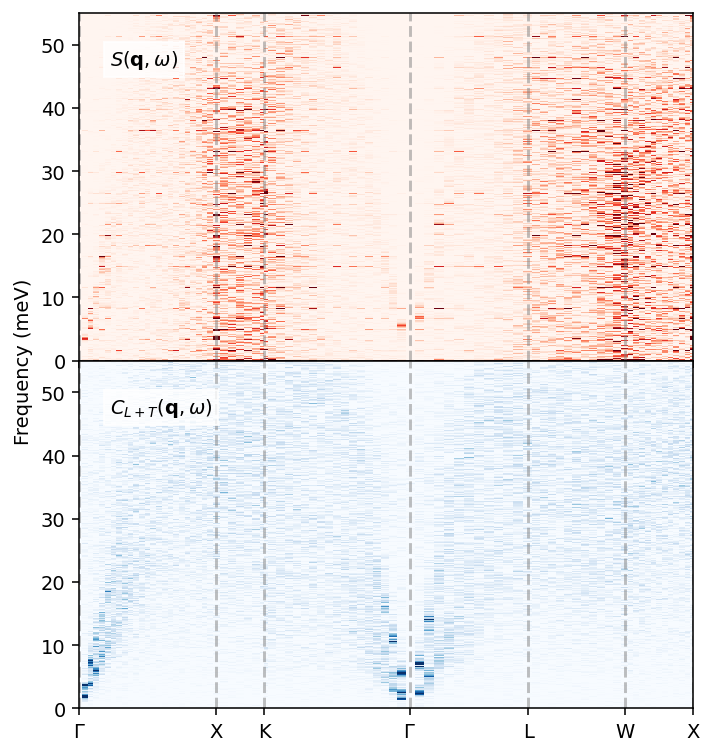

In [20]:
fig, axes = plt.subplots(figsize=(5.2, 5.5), nrows=2, dpi=140,
                         sharex=True, sharey=True)

ax = axes[0]
ax.pcolormesh(q_distances, conversion_factor * sample_disordered.omega,
              sample_disordered.Sqw_coh.T, cmap='Reds', vmin=0, vmax=8)
ax.text(0.05, 0.85, '$S(\mathbf{q}, \omega)$', transform=ax.transAxes,
        bbox={'color': 'white', 'alpha': 0.8, 'pad': 3})

ax = axes[1]
ax.pcolormesh(q_distances, conversion_factor * sample_disordered.omega,
              sample_disordered.Clqw.T + sample_disordered.Ctqw.T, cmap='Blues', vmin=0, vmax=10e-3)
ax.text(0.05, 0.85, '$C_{L+T}(\mathbf{q}, \omega)$', transform=ax.transAxes,
        bbox={'color': 'white', 'alpha': 0.8, 'pad': 3})

for ax in axes:
    xticks = []
    xticklabels = []
    for q_dist, q_label in q_labels.items():
        ax.axvline(q_dist, c='0.5', alpha=0.5, ls='--')
        xticks.append(q_dist)
        xticklabels.append(q_label.replace('GAMMA', r'$\Gamma$'))

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)

ax.set_xlim([0, q_distances.max()])
ax.set_ylim([0, 55])

ax.set_ylabel('Frequency (meV)', y=1)

fig.tight_layout()
fig.subplots_adjust(hspace=0)

With the dynamic structure factors and current correlation at hand for both the ordered (B2) and the disordered system, we can readily compare the two, and note the smearing of the bands that arises in the disordered case. One might consider averaging the disordered case over $\boldsymbol{q}$ instead, following the approach commonly used for liquids.